In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import random
import copy

In [2]:
gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    device = 'cuda:' + str(gpu_ids[0])  # 여기서 gpu 번호 고르기
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

[0]
['NVIDIA GeForce RTX 3080']
cuda


In [3]:
num_samples = 500
# num_samples = 1000
# num_samples = 2000
# num_samples = (1000,1000)

points, labels = make_moons(n_samples=num_samples, shuffle=True ,noise=0.1)

In [4]:
points_l = np.array((
    (-0.9, 0.25),
    (0.4, 1.05),
    (0.8, 0.6),
    (0.9, 0.05),
    (0.2, 0.1), # class 2 왼쪽 끝
    (0.7, -0.4),
    (0.85, -0.35),
    (1.7, -0.3),
    (1.9, 0.2)
))
labels_l = np.array((0,
                     0,
                     0,
                     0,
                     1,
                     1,
                     1,
                     1,
                     1))

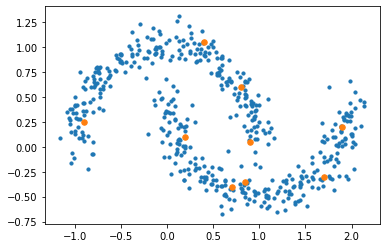

In [5]:
plt.scatter(points[:,0],points[:,1], s=10)
plt.scatter(points_l[:,0],points_l[:,1], s=30)

In [6]:
offset = random.randint(-10, 10)
while(offset == 0):
    offset = random.randint(-10, 10)
offset = 0

points += offset
points_l += offset

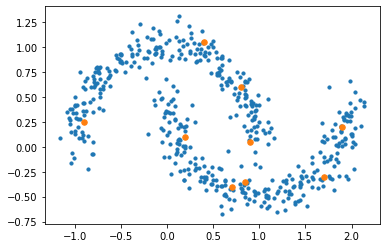

In [7]:
plt.scatter(points[:,0],points[:,1], s=10)
plt.scatter(points_l[:,0],points_l[:,1], s=30)

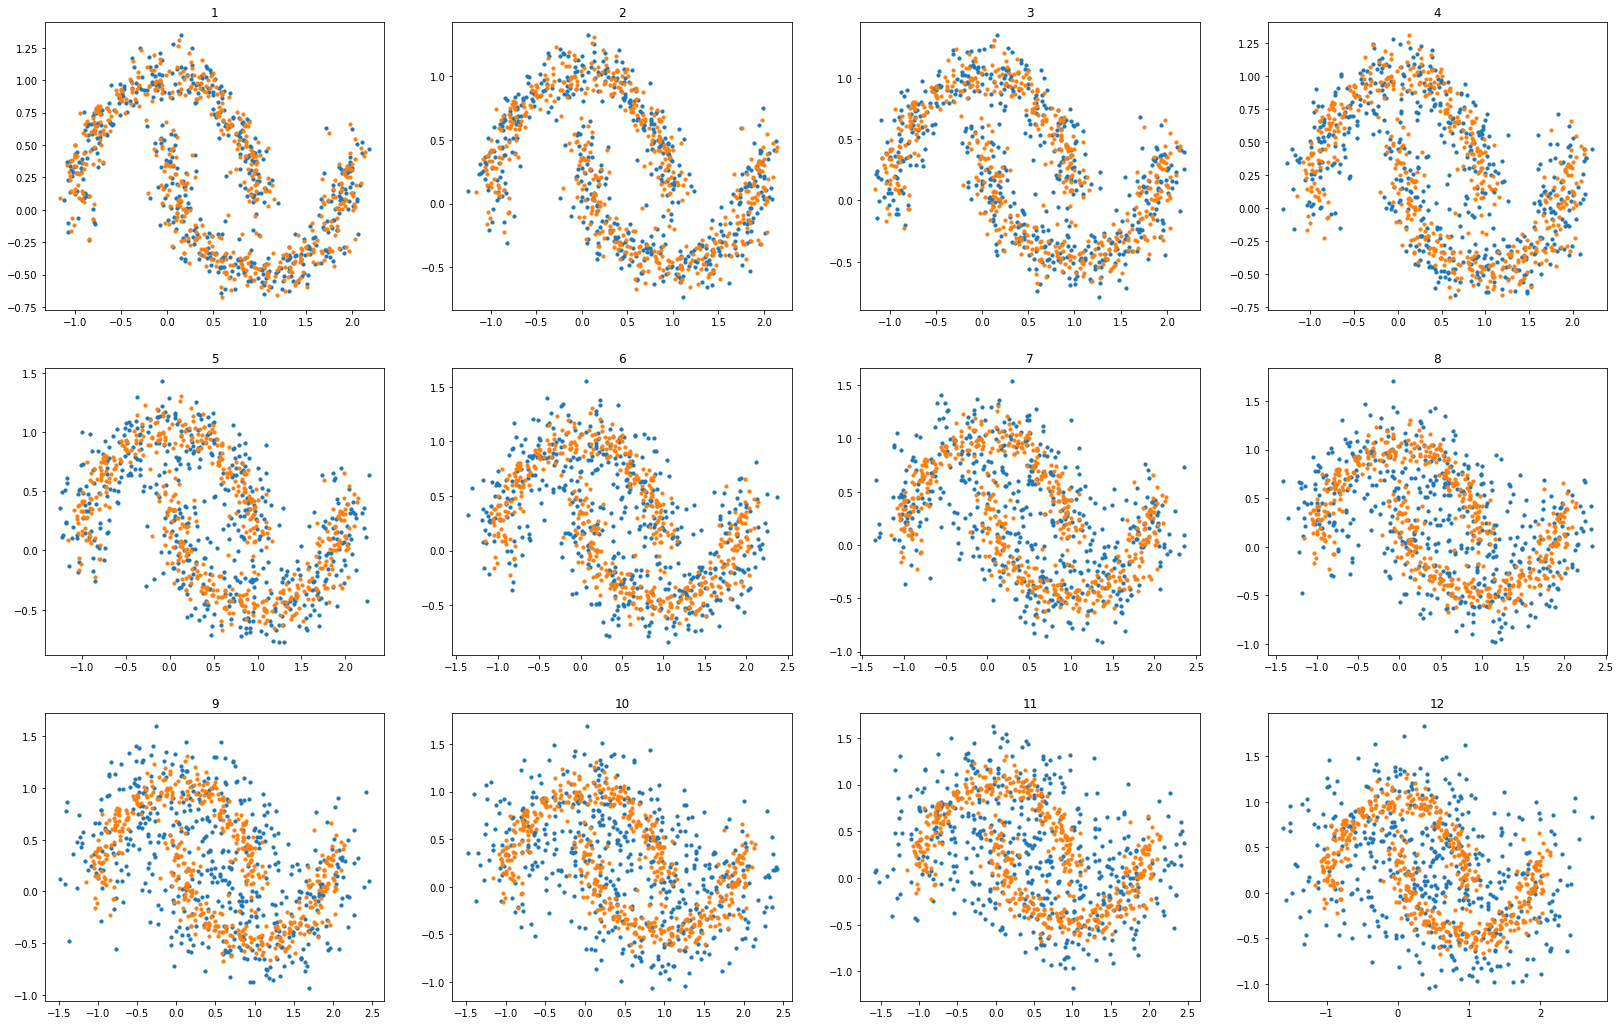

In [8]:
gridshape = (3,4)
marker_size = 0.1
num = 12

jr = num//4
for i in range(4):
    for j in range(jr):
        loc = (j,i)
        ax = plt.subplot2grid(gridshape, loc)
        point_noise = points + (torch.rand(size=points.shape).numpy()-0.5) * (0.1*((i+1)+(jr+1)*j))
        plt.scatter(point_noise[:,0],point_noise[:,1], s=10)
        plt.scatter(points[:,0],points[:,1], s=10)
        plt.title(((i+1)+(jr+1)*j))

ax.figure.set(figwidth=28, figheight=6 * jr)
plt.show()

In [9]:
class TMClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=32),
            # nn.Sigmoid(),
            nn.ReLU(),
            # nn.Linear(in_features=8, out_features=8),
            # nn.Sigmoid(),
            # nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            # nn.Sigmoid(),
            nn.ReLU(),
            # nn.Linear(in_features=16, out_features=16),
            # # nn.Sigmoid(),
            # nn.ReLU(),
            nn.Linear(in_features=32, out_features=2)
        )

        self.init_weight()

    def init_weight(self):
        for layer in self.layers:
            if(isinstance(layer, nn.Linear)):
                nn.init.uniform_(layer.weight, -1, 1)

    def forward(self, x):
        return self.layers(x)

In [10]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)
        self.transform = transform
        self.len = len(x_data)
    
    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]
        
        if self.transform:
            sample = self.transform(sample)   #self.transform이 None이 아니라면 전처리
        return sample 
    
    def __len__(self):
        return self.len

In [11]:
labeledData = MyDataset(points_l, labels_l)
unlabeledData = MyDataset(points, labels)

labeledLoader = DataLoader(labeledData, batch_size=labeledData.len, shuffle=True)
unlabeledLoader = DataLoader(unlabeledData, batch_size=num_samples, shuffle=True)

In [12]:
x = np.linspace(-1.5+offset, 2.5+offset, num=800)
y = np.linspace(-1.0+offset, 1.5+offset, num=500)

X,Y = np.meshgrid(x,y)

marker_size = 0.1
# plt.scatter(X, Y)

In [13]:
arr = np.stack((X.flatten(),Y.flatten()),axis=1)

In [14]:
def DrawDecisionBoundary(arr, model):
    renderData = MyDataset(arr, np.zeros_like(arr))
    renderLoader = DataLoader(renderData, batch_size=1024, shuffle=False, drop_last=False)

    preds = np.array([])
    for point,_ in renderLoader:
        _, pred = torch.max(model(point), dim=-1)
        preds = np.concatenate((preds, pred.numpy()))

    pred_points_0 = []
    pred_points_1 = []

    for i in range(arr.shape[0]):
        if(preds[i] == 0):
            pred_points_0.append(arr[i])
        else:
            pred_points_1.append(arr[i])

    return pred_points_0, pred_points_1

In [15]:
def meta_pseudo_labels_step(teacher_model,
                            teacher_optimizer,
                            student_model,
                            student_optimizer,
                            uo_data,
                            ua_data,
                            l_data,
                            l_label,
                            step):
    teacher_optimizer.zero_grad()
    student_optimizer.zero_grad()

    loss_fn = nn.CrossEntropyLoss()
    threshold = 0.6
    lambda_u = 0.8
    uda_step = 5000

    #### teacher UDA loss
    output_t_uo = teacher_model(uo_data)
    soft_pseudo_label = nn.functional.softmax(output_t_uo / 0.75, dim=-1).detach()
    soft_pseudo_label.requires_grad = False
    
    output_t_ua = teacher_model(ua_data)
    loss_t_u = torch.mul(soft_pseudo_label, torch.log_softmax(output_t_ua, dim=-1))
    max_probs, _ = torch.max(soft_pseudo_label, dim=-1, keepdim=True)
    mask = torch.greater_equal(max_probs, threshold).type(torch.float32)

    weight_u = min(1., (step/uda_step)) * lambda_u
    
    loss_t_u = torch.mean(torch.mul(-loss_t_u, mask)) # consistency loss
    loss_t_u = weight_u * loss_t_u

    #### teacher supervised loss
    output_t_l = teacher_model(l_data)
    loss_t_supervised = loss_fn(nn.functional.softmax(output_t_l, dim=-1), l_label)

    #### student performance old
    output_l_old = student_model(l_data)
    loss_l_old = loss_fn(nn.functional.softmax(output_l_old, dim=-1),
                            l_label).detach()
    loss_l_old.requires_grad = False
    
    #### student loss
    output_ua = student_model(ua_data)
    student_loss = loss_fn(nn.functional.softmax(output_ua, dim=-1),
                #    torch.argmax(soft_pseudo_label, dim=-1).long())  # hard pseudo label -> compute MPL loss using Taylor approximation
                   soft_pseudo_label)   # soft pseudo label -> compute MPL loss using autograd
    
    #### student update
    student_optimizer.zero_grad()
    student_loss.backward()
    student_optimizer.step()

    #### student performance new
    output_l_new =student_model(l_data)
    loss_l_new = loss_fn(nn.functional.softmax(output_l_new, dim=-1),
                            l_label).detach()
    loss_l_new.requires_grad = False
    
    #### compute MPL loss
    ## using hard pseudo label & Taylor approximation
    # dot_product = (loss_l_new - loss_l_old)
    # loss_t_mpl = torch.argmax(nn.functional.softmax(output_t_ua, dim=-1), dim=-1, keepdim=True)
    # loss_t_mpl = -torch.mean(torch.mul(loss_t_mpl, nn.functional.log_softmax(output_t_ua, dim=-1)))
    # loss_t_mpl = loss_t_mpl * dot_product
    ## using soft pseudo label
    loss_t_mpl = loss_fn(output_l_new, l_label)

    #### teacher update
    teacher_optimizer.zero_grad()
    teacher_loss = loss_t_supervised + loss_t_u + loss_t_mpl
    teacher_loss.backward()
    
    teacher_optimizer.step()

    return teacher_loss.detach().numpy(), student_loss.detach().numpy(), loss_t_mpl.detach().numpy(), loss_t_u.detach().numpy()

In [16]:
def meta_pseudo_labels_woUDA_step(teacher_model,
                            teacher_optimizer,
                            student_model,
                            student_optimizer,
                            uo_data,
                            ua_data,
                            l_data,
                            l_label,
                            step):
    teacher_optimizer.zero_grad()
    student_optimizer.zero_grad()

    loss_fn = nn.CrossEntropyLoss()

    #### teacher UDA loss
    output_t_uo = teacher_model(uo_data)
    soft_pseudo_label = nn.functional.softmax(output_t_uo / 0.75, dim=-1).detach()
    soft_pseudo_label.requires_grad = False

    #### teacher supervised loss
    output_t_l = teacher_model(l_data)
    loss_t_supervised = loss_fn(nn.functional.softmax(output_t_l, dim=-1), l_label)

    #### student performance old
    output_l_old = student_model(l_data)
    loss_l_old = loss_fn(nn.functional.softmax(output_l_old, dim=-1),
                            l_label).detach()
    loss_l_old.requires_grad = False
    
    #### student loss
    output_ua = student_model(ua_data)
    student_loss = loss_fn(nn.functional.softmax(output_ua, dim=-1),
                #    torch.argmax(soft_pseudo_label, dim=-1).long())  # hard pseudo label -> compute MPL loss using Taylor approximation
                   soft_pseudo_label)   # soft pseudo label -> compute MPL loss using autograd
    
    #### student update
    student_optimizer.zero_grad()
    student_loss.backward()
    student_optimizer.step()

    #### student performance new
    output_l_new =student_model(l_data)
    loss_l_new = loss_fn(nn.functional.softmax(output_l_new, dim=-1),
                            l_label).detach()
    loss_l_new.requires_grad = False
    
    #### compute MPL loss
    ## using hard pseudo label & Taylor approximation
    # dot_product = (loss_l_new - loss_l_old)
    # loss_t_mpl = torch.argmax(nn.functional.softmax(output_t_ua, dim=-1), dim=-1, keepdim=True)
    # loss_t_mpl = -torch.mean(torch.mul(loss_t_mpl, nn.functional.log_softmax(output_t_ua, dim=-1)))
    # loss_t_mpl = loss_t_mpl * dot_product
    ## using soft pseudo label
    loss_t_mpl = loss_fn(output_l_new, l_label)

    #### teacher update
    teacher_optimizer.zero_grad()
    teacher_loss = loss_t_supervised + loss_t_mpl
    teacher_loss.backward()
    
    teacher_optimizer.step()

    return teacher_loss.detach().numpy(), student_loss.detach().numpy(), loss_t_mpl.detach().numpy()

Epoch: 0 	Teacher Loss: 1.9026 	Student Loss: 0.8690 	MPL Loss: 1.27619016 	UDA Loss: 0.00000000
	Teacher Acc: 351.0 / 500 	Student Acc: 284.0 / 500


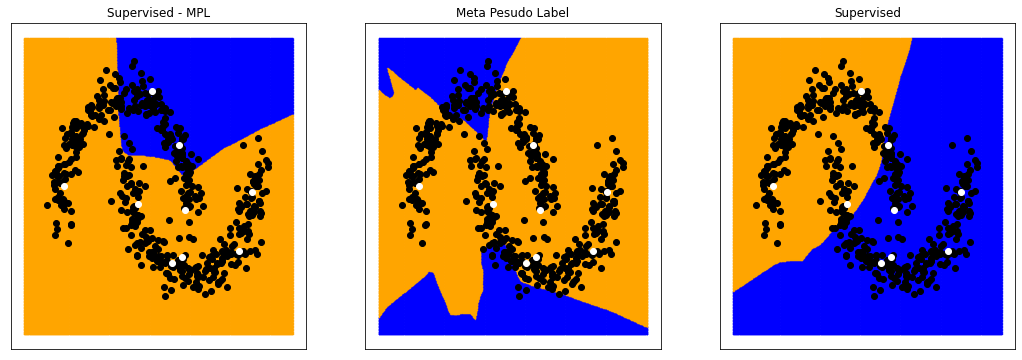

Epoch: 100 	Teacher Loss: 0.5995 	Student Loss: 0.4265 	MPL Loss: 0.25087526 	UDA Loss: 0.00142881
	Teacher Acc: 454.0 / 500 	Student Acc: 475.0 / 500
Epoch: 200 	Teacher Loss: 0.5034 	Student Loss: 0.4010 	MPL Loss: 0.17018458 	UDA Loss: 0.00248897
	Teacher Acc: 462.0 / 500 	Student Acc: 461.0 / 500
Epoch: 300 	Teacher Loss: 0.4441 	Student Loss: 0.3872 	MPL Loss: 0.11668858 	UDA Loss: 0.00317158
	Teacher Acc: 468.0 / 500 	Student Acc: 467.0 / 500
Epoch: 400 	Teacher Loss: 0.4078 	Student Loss: 0.3759 	MPL Loss: 0.08304086 	UDA Loss: 0.00389065
	Teacher Acc: 470.0 / 500 	Student Acc: 472.0 / 500
Epoch: 500 	Teacher Loss: 0.3843 	Student Loss: 0.3662 	MPL Loss: 0.06109650 	UDA Loss: 0.00423064
	Teacher Acc: 473.0 / 500 	Student Acc: 474.0 / 500
Epoch: 600 	Teacher Loss: 0.3677 	Student Loss: 0.3598 	MPL Loss: 0.04614881 	UDA Loss: 0.00383385
	Teacher Acc: 490.0 / 500 	Student Acc: 489.0 / 500
Epoch: 700 	Teacher Loss: 0.3574 	Student Loss: 0.3506 	MPL Loss: 0.03575658 	UDA Loss: 0.0047

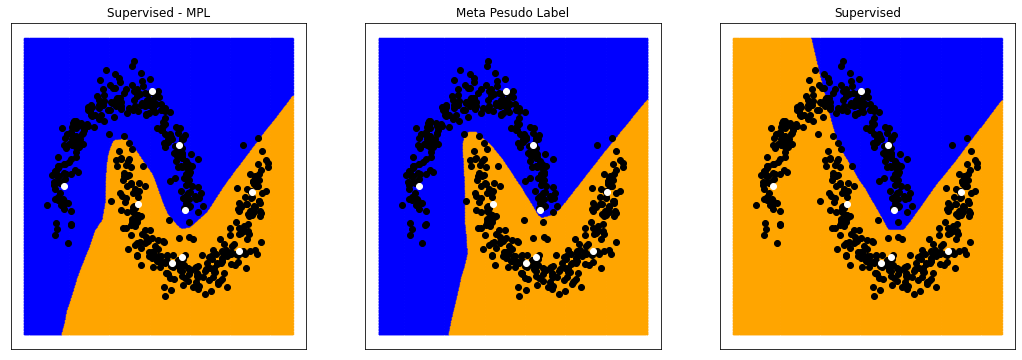

Epoch: 1100 	Teacher Loss: 0.3519 	Student Loss: 0.3307 	MPL Loss: 0.03243139 	UDA Loss: 0.00423476
	Teacher Acc: 495.0 / 500 	Student Acc: 495.0 / 500
Epoch: 1200 	Teacher Loss: 0.3529 	Student Loss: 0.3294 	MPL Loss: 0.03377172 	UDA Loss: 0.00411599
	Teacher Acc: 496.0 / 500 	Student Acc: 495.0 / 500
Epoch: 1300 	Teacher Loss: 0.3547 	Student Loss: 0.3293 	MPL Loss: 0.03531972 	UDA Loss: 0.00452707
	Teacher Acc: 496.0 / 500 	Student Acc: 495.0 / 500


In [17]:
unlabeled_iterator = unlabeledLoader.__iter__()
labeled_iterator = labeledLoader.__iter__()

supervised = TMClassifier()
supervised_mpl = TMClassifier()
metaPseudoLabel = TMClassifier()
supervised_mpl_woUDA = TMClassifier()
metaPseudoLabel_woUDA = TMClassifier()

supervised.train(True)
supervised_mpl.train(True)
metaPseudoLabel.train(True)
supervised_mpl_woUDA.train(True)
metaPseudoLabel_woUDA.train(True)

# lr = 2e-1
opt_s = torch.optim.SGD(supervised.parameters(), lr=1e-1)
opt_st = torch.optim.SGD(supervised_mpl.parameters(), lr=1e-1)
opt_mpl = torch.optim.SGD(metaPseudoLabel.parameters(), lr=1e-1)
opt_st_woUDA = torch.optim.SGD(supervised_mpl_woUDA.parameters(), lr=1e-1)
opt_mpl_woUDA = torch.optim.SGD(metaPseudoLabel_woUDA.parameters(), lr=1e-1)
# opt_st = torch.optim.Adam(supervised_mpl.parameters(), lr=1e-1)
# opt_mpl = torch.optim.Adam(metaPseudoLabel.parameters(), lr=1e-1)

epoch = 0
# max_epoch = 2e5+1

best_acc = 0.8

noise = 0.1

while(True):
    try:
        uo_point, _ = unlabeled_iterator.__next__()
    except:
        unlabeled_iterator = unlabeledLoader.__iter__()
        uo_point, _ = unlabeled_iterator.__next__()
    try:
        l_point, l_label = labeled_iterator.__next__()
    except:
        labeled_iterator = labeledLoader.__iter__()
        l_point, l_label = labeled_iterator.__next__()
        
    # ua_point = uo_point + (torch.rand(u_point.shape)-0.5)*noise
    ua_point = uo_point + torch.rand(uo_point.shape)*noise

    
    supervised_mpl.train(True)
    metaPseudoLabel.train(True)
    supervised_mpl_woUDA.train(True)
    metaPseudoLabel_woUDA.train(True)
    
    step = meta_pseudo_labels_step(teacher_model=supervised_mpl,
                                   teacher_optimizer=opt_st,
                                   student_model=metaPseudoLabel,
                                   student_optimizer=opt_mpl,
                                   uo_data=uo_point,
                                   ua_data=ua_point,
                                   l_data=l_point,
                                   l_label=l_label,
                                   step=epoch)
    
    sstep = meta_pseudo_labels_woUDA_step(teacher_model=supervised_mpl_woUDA,
                                          teacher_optimizer=opt_st_woUDA,
                                          student_model=metaPseudoLabel_woUDA,
                                          student_optimizer=opt_mpl_woUDA,
                                          uo_data=uo_point,
                                          ua_data=ua_point,
                                          l_data=l_point,
                                          l_label=l_label,
                                          step=epoch)
    
    supervised_mpl.train(False)
    metaPseudoLabel.train(False)
    supervised_mpl_woUDA.train(False)
    metaPseudoLabel_woUDA.train(False)

    infer = supervised_mpl(torch.tensor(points).type(torch.float32))
    teacher_acc = sum((torch.argmax(infer, -1).numpy() == labels).astype(int)) / num_samples
    
    infer = metaPseudoLabel(torch.tensor(points).type(torch.float32))
    student_acc = sum((torch.argmax(infer, -1).numpy() == labels).astype(int)) / num_samples

    if(student_acc > best_acc):
            best_acc = student_acc
            best_student_model = copy.deepcopy(metaPseudoLabel)

    if float(student_acc) > 0.99:
        break
    
    if(epoch%1e2 == 0):
        print(f'Epoch: {epoch} \tTeacher Loss: {step[0].item():.4f} \tStudent Loss: {step[1].item():.4f} \tMPL Loss: {step[2].item():.8f} \tUDA Loss: {step[3].item():.8f}')
        print(f'\tTeacher Acc: {teacher_acc.item()*num_samples} / {num_samples} \tStudent Acc: {student_acc.item()*num_samples} / {num_samples}')


    if(epoch < 1e5):
        opt_s.zero_grad()
        out_s = supervised(l_point)
        loss_s = nn.functional.cross_entropy(nn.functional.softmax(out_s, dim=-1), l_label)
        loss_s.backward()
        opt_s.step()

    if(epoch%1e3 == 0): 
        msg = ""
        try:
            s_pred_points_0, s_pred_points_1 = DrawDecisionBoundary(arr, supervised)
            s_mpl_pred_points_0, s_mpl_pred_points_1 = DrawDecisionBoundary(arr, supervised_mpl)
            mpl_pred_points_0, mpl_pred_points_1 = DrawDecisionBoundary(arr, metaPseudoLabel)
            
            gridshape = (1,3)

            loc = (0,0)
            ax = plt.subplot2grid(gridshape, loc)
            ax.set_xticks([])
            ax.set_yticks([])

            try:
                plt.scatter(np.array(s_mpl_pred_points_0)[:,0],
                             np.array(s_mpl_pred_points_0)[:,1], 
                             c='blue', s=marker_size)
            except:
                msg = msg + 'teacher class 0 exceed.\n'
                # print(msg)
            try:
                plt.scatter(np.array(s_mpl_pred_points_1)[:,0],
                             np.array(s_mpl_pred_points_1)[:,1],
                              c='orange', s=marker_size)
            except:
                msg = msg + 'teacher class 1 exceed.\n'
                # print(msg)
            plt.scatter(points[:,0],points[:,1], c='black')
            plt.scatter(points_l[:,0],points_l[:,1], c='white')
            plt.title('Supervised - MPL')

            loc = (0,1)
            ax = plt.subplot2grid(gridshape, loc)
            ax.set_xticks([])
            ax.set_yticks([])

            try:
                plt.scatter(np.array(mpl_pred_points_0)[:,0],
                             np.array(mpl_pred_points_0)[:,1], 
                             c='blue', s=marker_size)
            except:
                msg = msg + 'student class 0 exceed.\n'
                # print(msg)
            try:
                plt.scatter(np.array(mpl_pred_points_1)[:,0],
                             np.array(mpl_pred_points_1)[:,1], 
                             c='orange', s=marker_size)
            except:
                msg = msg + 'student class 1 exceed.\n'
                # print(msg)
            plt.scatter(points[:,0],points[:,1], c='black')
            plt.scatter(points_l[:,0],points_l[:,1], c='white')
            plt.title('Meta Pesudo Label')
            

            loc = (0,2)
            ax = plt.subplot2grid(gridshape, loc)
            ax.set_xticks([])
            ax.set_yticks([])

            try:
                plt.scatter(np.array(s_pred_points_0)[:,0],
                             np.array(s_pred_points_0)[:,1], 
                             c='blue', s=marker_size)
            except:
                msg = msg + 'ref class 0 exceed.\n'
                # print(msg)
            try:
                plt.scatter(np.array(s_pred_points_1)[:,0],
                             np.array(s_pred_points_1)[:,1], 
                             c='orange', s=marker_size)
            except:
                msg = msg + 'ref class 1 exceed.\n'
                # print(msg)
            plt.scatter(points[:,0],points[:,1], c='black')
            plt.scatter(points_l[:,0],points_l[:,1], c='white')
            plt.title('Supervised')

            ax.figure.set(figwidth=18, figheight=6)

            plt.show()
        except:
            print(msg)

    epoch += 1


In [18]:
while(False):
# while(epoch < max_epoch):
    for point, label in unlabeledLoader:
        ##### concatenate unlabeled data and labeled data for efficiency
        batch_size = point.shape[0]
        point_noise = point + torch.rand(size=point.shape) * noise
        # point_noise = point + (torch.rand(size=point.shape).numpy()-0.5) * noise
        points_ = torch.concat((point.to(device), point_noise.to(device), points_l_tensor)).float()
        
        # opt_mpl.zero_grad()
        # opt_st.zero_grad()
        
        ##### run teacher model
        # output_t = supervised_mpl(points_)

        # output_t_uo = output_t[:batch_size] # unlabeled original
        # output_t_ua = output_t[batch_size:batch_size*2] # unlabeled augmented
        # output_t_l = output_t[batch_size*2:] # labeled
        # del output_t
        output_t_uo = supervised_mpl(point.to(device))
        
        # loss_t_supervised = creterion(torch.softmax(output_t_l, dim=-1), labels_l_tensor)

        ##### get pseudo_label & compute uda loss
        # # soft_pseudo_label = torch.softmax(output_t_uo, dim=-1)
        # # soft_pseudo_label = torch.softmax(output_t_uo.detach(), dim=-1)
        soft_pseudo_label = torch.softmax(output_t_uo / 0.7, dim=-1).detach() # args.temperture

        max_probs, _ = torch.max(soft_pseudo_label, dim=-1, keepdim=True)
        mask = torch.greater_equal(max_probs, threshold).type(torch.float32)
        # mask = max_probs.ge(threshold).float()  # greater_equal
        # weight_u = lambda_u * min(1., (epoch + 1) / 500.)
        # # loss_t_u = torch.mean(-(soft_pseudo_label * torch.log_softmax(output_t_ua, dim=-1)).sum(dim=-1)) # consistency loss
        loss_t_u = torch.mul(soft_pseudo_label, torch.log_softmax(output_t_ua, dim=-1))
        loss_t_u = torch.mean(torch.mul(-loss_t_u, mask)) # consistency loss
        loss_t_uda = loss_t_u
        # # loss_t_uda = loss_t_u * lambda_u
        # loss_t_uda = loss_t_u * weight_u
        
        # soft_pseudo_label = torch.softmax(output_t_uo.detach() / 0.7, dim=-1)
        # loss_t_uda = creterion(output_t_ua, soft_pseudo_label)

        ##### run student model
        # output = metaPseudoLabel(points_)
        # output_ua = output[batch_size:batch_size*2]
        # output_l = output[batch_size*2:]
        # del output
        output_ua = metaPseudoLabel(point_noise.to(device).float())
        output_l = metaPseudoLabel(points_l_tensor.to(device))

        loss_old_l = creterion(nn.functional.softmax(output_l, dim=-1),
                               labels_l_tensor).detach()

        # student is trained with augmented data 
        # https://github.com/google-research/google-research/issues/534#issuecomment-769559165

        opt_mpl.zero_grad()

        loss = creterion(nn.functional.softmax(output_ua, dim=-1),
                        torch.argmax(soft_pseudo_label, dim=-1).long())
        # loss = creterion(output_ua, torch.softmax(output_t_uo.detach(), dim=-1))    # get loss of student on unlabeled augmented input using pseudo label
        # loss = creterion(output_ua, output_t_uo.detach())    # get loss of student on unlabeled augmented input using pseudo label

        ##### update student
        
        loss.backward()#retain_graph=True)
        opt_mpl.step()

        ##### compute MPL loss with updated student
        output_new_l = metaPseudoLabel(points_l_tensor)
        loss_new_l = creterion(nn.functional.softmax(output_new_l, dim=-1),
                               labels_l_tensor).detach()
                               
        dot_product = (loss_new_l - loss_old_l)
        loss_t_mpl = torch.argmax(nn.functional.softmax(output_t_ua, dim=-1), dim=-1, keepdim=True)
        loss_t_mpl = -torch.mean(torch.mul(loss_t_mpl, nn.functional.log_softmax(output_t_ua, dim=-1)))

        # output_l = metaPseudoLabel(points_l_tensor)
        # loss_t_mpl = creterion(output_l, labels_l_tensor)
        # loss_t_mpl = creterion(output_l.detach(), labels_l_tensor)

        opt_st.zero_grad()
        loss_t = loss_t_mpl + loss_t_supervised + loss_t_uda
        loss_t.backward()
        opt_st.step()

    
    infer = metaPseudoLabel(point.to(device))
    student_acc = sum((torch.argmax(infer, -1) == label.to(device)).type(torch.int))

    if(student_acc/batch_size > best_acc):
            best_acc = student_acc
            best_student_model = copy.deepcopy(metaPseudoLabel)

    if float(student_acc/batch_size) > 0.99:
        break
    
    if(epoch%1e3 == 0):
        _, preds = torch.max(output_t_uo, dim=-1)
        acc_t = torch.sum(preds == label.to(device))
        

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tTeacher Acc: {acc_t.item()} / {point.shape[0]} \tMPL Acc: {student_acc.item()} / {point.shape[0]}')
        print(f'\t UDA loss: {loss_t_uda:.4f}\t MPL loss: {loss_t_mpl:.4f}\t Supervised loss: {loss_t_supervised:.4f}')


    if(epoch%5e3 == 0):
        try:
            s_mpl_preds = np.array([])
            mpl_preds = np.array([])

            for point, _ in renderLoader:
                _, s_mpl_pred = torch.max(supervised_mpl(point.float().to(device)), 1)
                _, mpl_pred = torch.max(metaPseudoLabel(point.float().to(device)), dim=-1)

                s_mpl_preds = np.concatenate((s_mpl_preds,s_mpl_pred.cpu().numpy()))
                mpl_preds = np.concatenate((mpl_preds,mpl_pred.cpu().numpy()))

            s_mpl_pred_points_0 = []
            s_mpl_pred_points_1 = []
            mpl_pred_points_0 = []
            mpl_pred_points_1 = []

            for i in range(arr.shape[0]):
                if(s_mpl_preds[i] == 0):
                    s_mpl_pred_points_0.append(arr[i])
                else:
                    s_mpl_pred_points_1.append(arr[i])
                if(mpl_preds[i] == 0):
                    mpl_pred_points_0.append(arr[i])
                else:
                    mpl_pred_points_1.append(arr[i])

                    gridshape = (2, 2)
            
            gridshape = (1,2)

            loc = (0,0)
            ax = plt.subplot2grid(gridshape, loc)
            ax.set_xticks([])
            ax.set_yticks([])

            plt.scatter(np.array(s_mpl_pred_points_0)[:,0], np.array(s_mpl_pred_points_0)[:,1], s=marker_size)
            plt.scatter(np.array(s_mpl_pred_points_1)[:,0], np.array(s_mpl_pred_points_1)[:,1], s=marker_size)
            plt.scatter(points[:,0],points[:,1])
            plt.scatter(points_l[:,0],points_l[:,1])
            plt.title('Supervised - MPL')

            loc = (0,1)
            ax = plt.subplot2grid(gridshape, loc)
            ax.set_xticks([])
            ax.set_yticks([])

            plt.scatter(np.array(mpl_pred_points_0)[:,0], np.array(mpl_pred_points_0)[:,1], s=marker_size)
            plt.scatter(np.array(mpl_pred_points_1)[:,0], np.array(mpl_pred_points_1)[:,1], s=marker_size)
            plt.scatter(points[:,0],points[:,1])
            plt.scatter(points_l[:,0],points_l[:,1])
            plt.title('Meta Pesudo Label')

            ax.figure.set(figwidth=14, figheight=6)

            plt.show()
        except:
            print('pass')

    epoch += 1

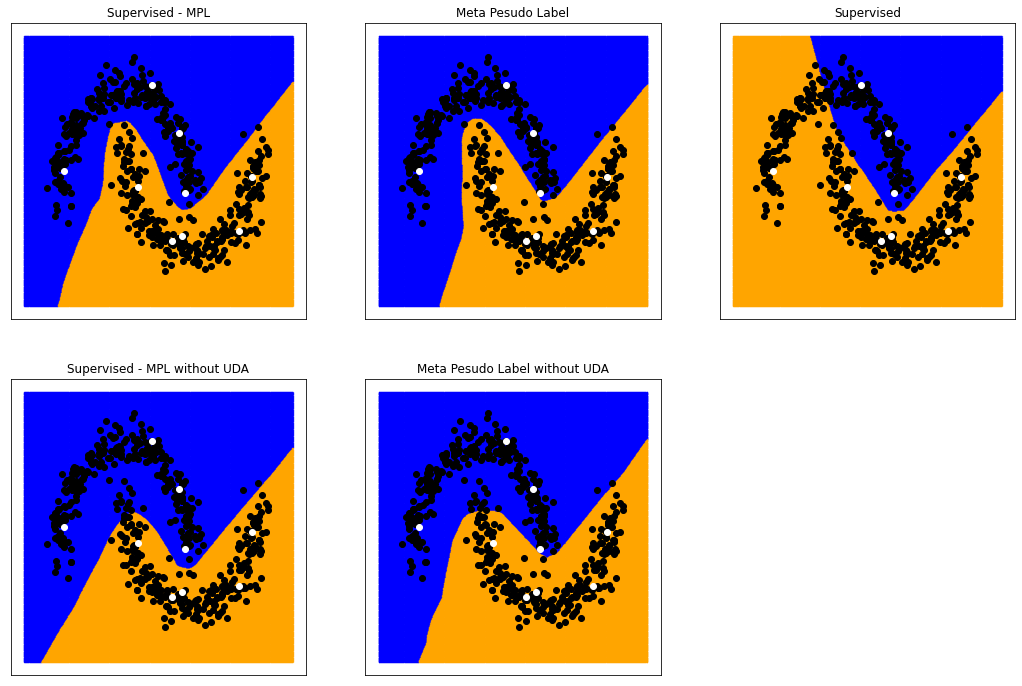

In [19]:
gridshape = (2, 3)

s_pred_points_0, s_pred_points_1 = DrawDecisionBoundary(arr, supervised)
s_mpl_pred_points_0, s_mpl_pred_points_1 = DrawDecisionBoundary(arr, supervised_mpl)
mpl_pred_points_0, mpl_pred_points_1 = DrawDecisionBoundary(arr, metaPseudoLabel)
s_mpl_woUDA_pred_points_0, s_mpl_woUDA_pred_points_1 = DrawDecisionBoundary(arr, supervised_mpl_woUDA)
mpl_woUDA_pred_points_0, mpl_woUDA_pred_points_1 = DrawDecisionBoundary(arr, metaPseudoLabel_woUDA)

loc = (0,0)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(s_mpl_pred_points_0)[:,0], np.array(s_mpl_pred_points_0)[:,1], c='blue', s=marker_size)
plt.scatter(np.array(s_mpl_pred_points_1)[:,0], np.array(s_mpl_pred_points_1)[:,1], c='orange', s=marker_size)
plt.scatter(points[:,0],points[:,1], c='black')
plt.scatter(points_l[:,0],points_l[:,1], c='white')
plt.title('Supervised - MPL')

loc = (0,1)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(mpl_pred_points_0)[:,0], np.array(mpl_pred_points_0)[:,1], c='blue', s=marker_size)
plt.scatter(np.array(mpl_pred_points_1)[:,0], np.array(mpl_pred_points_1)[:,1], c='orange', s=marker_size)
plt.scatter(points[:,0],points[:,1], c='black')
plt.scatter(points_l[:,0],points_l[:,1], c='white')
plt.title('Meta Pesudo Label')

loc = (0,2)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

try:
    plt.scatter(np.array(s_pred_points_0)[:,0], np.array(s_pred_points_0)[:,1], c='blue', s=marker_size)
except:
    None
try:
    plt.scatter(np.array(s_pred_points_1)[:,0], np.array(s_pred_points_1)[:,1], c='orange', s=marker_size)
except:
    None
plt.scatter(points[:,0],points[:,1], c='black')
plt.scatter(points_l[:,0],points_l[:,1], c='white')
plt.title('Supervised')

loc = (1,0)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(s_mpl_woUDA_pred_points_0)[:,0], np.array(s_mpl_woUDA_pred_points_0)[:,1], c='blue', s=marker_size)
plt.scatter(np.array(s_mpl_woUDA_pred_points_1)[:,0], np.array(s_mpl_woUDA_pred_points_1)[:,1], c='orange', s=marker_size)
plt.scatter(points[:,0],points[:,1], c='black')
plt.scatter(points_l[:,0],points_l[:,1], c='white')
plt.title('Supervised - MPL without UDA')

loc = (1,1)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(mpl_woUDA_pred_points_0)[:,0], np.array(mpl_woUDA_pred_points_0)[:,1], c='blue', s=marker_size)
plt.scatter(np.array(mpl_woUDA_pred_points_1)[:,0], np.array(mpl_woUDA_pred_points_1)[:,1], c='orange', s=marker_size)
plt.scatter(points[:,0],points[:,1], c='black')
plt.scatter(points_l[:,0],points_l[:,1], c='white')
plt.title('Meta Pesudo Label without UDA')

ax.figure.set(figwidth=18, figheight=6*2)

plt.show()